# Modeling - Binary Classification (Gun vs. Not Gun)

In [40]:
import joblib
import time
import matplotlib.pyplot as plt
import scipy
import numpy as np
from PIL import Image
from scipy import ndimage
from keras.preprocessing.image import ImageDataGenerator
from keras import models, layers
from tensorflow.keras.utils import array_to_img, load_img, img_to_array, to_categorical
from tensorflow.keras.callbacks import EarlyStopping

from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

import datetime
original_start = datetime.datetime.now()
start = datetime.datetime.now()

import os, shutil

np.random.seed(42)

In [41]:
# create directions for guns and not guns
data_gun_dir = 'image_data/gun'
data_not_gun_dir = 'image_data/not_gun/'

# new directory for the train test validation split
new_dir = 'split/'

In [42]:
# add gun images 
imgs_gun = [file for file in os.listdir(data_gun_dir) if file.endswith('.jpg')]

In [43]:
# check first ten 
imgs_gun[0:10]

['120px-RugerMuzzelite.jpg',
 'armas (2311).jpg',
 '120px-NEF_B32.jpg',
 'armas (2741).jpg',
 '120px-NambuType14Pistol.jpg',
 'armas (695).jpg',
 'armas (1497).jpg',
 'armas (1182).jpg',
 'armas (380).jpg',
 'armas (1478).jpg']

In [44]:
len(imgs_gun)

3967

In [45]:
# add not gun images
imgs_not_gun = [file for file in os.listdir(data_not_gun_dir) if file.endswith('.jpg')]

In [46]:
imgs_not_gun[0:10]

['-478.jpg',
 'smartphone_0049_box1.jpg',
 'smartphone_0048_box1.jpg',
 '004_0101.jpg',
 '-322.jpg',
 'smartphone_0817_box1.jpg',
 'smartphone_0487_box1.jpg',
 '-444.jpg',
 '-450.jpg',
 'smartphone_0816_box1.jpg']

In [47]:
len(imgs_not_gun)

2150

In [48]:
# below code creates new directory if not already created
# os.mkdir(new_dir)

In [49]:
# from the new directory, create new training, test, and val folders to store the guns and not guns
train_folder = os.path.join(new_dir, 'train')
train_gun = os.path.join(train_folder, 'gun')
train_not_gun = os.path.join(train_folder, 'not_gun')

test_folder = os.path.join(new_dir, 'test')
test_gun = os.path.join(test_folder, 'gun')
test_not_gun = os.path.join(test_folder, 'not_gun')

val_folder = os.path.join(new_dir, 'validation')
val_gun = os.path.join(val_folder, 'gun')
val_not_gun = os.path.join(val_folder, 'not_gun')

In [50]:
# os.mkdir(test_folder)
# os.mkdir(test_gun)
# os.mkdir(test_not_gun)

# os.mkdir(train_folder)
# os.mkdir(train_gun)
# os.mkdir(train_not_gun)

# os.mkdir(val_folder)
# os.mkdir(val_gun)
# os.mkdir(val_not_gun)

Now we will slice the images from `imgs_not_gun` into train, validation, and test folders and do the same for `imgs_gun` into train, validation, and test folders.

**Not Gun Images**

In [51]:
# train not_gun
imgs = imgs_not_gun[:1290]
for img in imgs:
    origin = os.path.join(data_not_gun_dir, img)
    destination = os.path.join(train_not_gun, img)
    shutil.copyfile(origin, destination)
# validation not_gun
imgs = imgs_not_gun[1290:1720]
for img in imgs:
    origin = os.path.join(data_not_gun_dir, img)
    destination = os.path.join(val_not_gun, img)
    shutil.copyfile(origin, destination)
# test not_gun
imgs = imgs_not_gun[1720:]
for img in imgs:
    origin = os.path.join(data_not_gun_dir, img)
    destination = os.path.join(test_not_gun, img)
    shutil.copyfile(origin, destination)

**Gun Images**

In [52]:
# train gun
imgs = imgs_gun[:2270]  # 2270 images
for img in imgs:
    origin = os.path.join(data_gun_dir, img)
    destination = os.path.join(train_gun, img)
    shutil.copyfile(origin, destination)
    
# validation gun
imgs = imgs_gun[2270:3027]  # 757 images
for img in imgs:
    origin = os.path.join(data_gun_dir, img)
    destination = os.path.join(val_gun, img)
    shutil.copyfile(origin, destination)

# test gun
imgs = imgs_gun[3027:]  # 757 images
for img in imgs:
    origin = os.path.join(data_gun_dir, img)
    destination = os.path.join(test_gun, img)
    shutil.copyfile(origin, destination)

Check how many images are in each set.

In [53]:
print('There are', len(os.listdir(train_gun)), 'gun images in the train set')
print('There are', len(os.listdir(val_gun)), 'gun images in the validation set')
print('There are', len(os.listdir(test_gun)), 'gun images in the test set')

There are 2392 gun images in the train set
There are 896 gun images in the validation set
There are 940 gun images in the test set


In [54]:
print('There are', len(os.listdir(train_not_gun)), 'not gun images in the train set')
print('There are', len(os.listdir(val_not_gun)), 'not gun images in the validation set')
print('There are', len(os.listdir(test_not_gun)), 'not gun images in the test set')

There are 1290 not gun images in the train set
There are 437 not gun images in the validation set
There are 450 not gun images in the test set


## Preprocessing Images 

- Normalize
- Set up image size
- Set up size of training, validation, and test sets

In [56]:
# get all the data in the directory split/train, and reshape them
# normalizees by rescaling
# set image size to 64 x 64
# batch size varies for each set size

train_generator = ImageDataGenerator(rescale=1./255).flow_from_directory(
                                                     train_folder, 
                                                     target_size=(256, 256),
                                                     batch_size=3566) # total from train

# get all the data in the directory split/validation, and reshape them
val_generator = ImageDataGenerator(rescale=1./255).flow_from_directory(
                                                   val_folder, 
                                                   target_size=(256, 256),
                                                   batch_size = 1196) # total from val

# get all the data in the directory split/test, and reshape them
test_generator = ImageDataGenerator(rescale=1./255).flow_from_directory(
                                                    test_folder, 
                                                    target_size=(256, 256),
                                                    batch_size = 1209) # total from test

Found 3682 images belonging to 2 classes.
Found 1333 images belonging to 2 classes.
Found 1390 images belonging to 2 classes.


In [57]:
# create the data sets and label the images as gun or not gun
train_images, train_labels = next(train_generator)
test_images, test_labels = next(test_generator)
val_images, val_labels = next(val_generator)

In [58]:
# check shape of images in train set
train_images.shape

(3566, 256, 256, 3)

In [59]:
# check labels for train
train_labels

array([[1., 0.],
       [0., 1.],
       [0., 1.],
       ...,
       [1., 0.],
       [0., 1.],
       [1., 0.]], dtype=float32)

In [60]:
train_generator.class_indices

{'gun': 0, 'not_gun': 1}

After running the image sets through the image data generators, the labels generated are opposite of what we'd like. To simply fix, we reassign the labels as follows below:

In [61]:
# current labels are swapped; below code simply reassigns the labels for 0 not gun, 1 for gun
train_labels = 1 - train_labels
test_labels = 1 - test_labels
val_labels = 1 - val_labels

Label: [0. 1.]


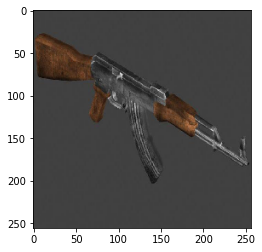

In [62]:
# check an example gun image
sample_train_image = train_images[100]
sample_train_label = train_labels[100]
display(plt.imshow(sample_train_image))
print('Label: {}'.format(sample_train_label))

Label: [1. 0.]


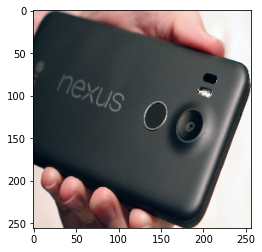

In [63]:
# check an example not gun image
sample_train_image = train_images[666]
sample_train_label = train_labels[666]
display(plt.imshow(sample_train_image))
print('Label: {}'.format(sample_train_label))

### Visualize the Image Dataset

In [64]:
# function that plots images and labels
def plots(ims, figsize = (20,4), rows = 1, interp = False, titles = None):
    """
    Takes in image set (recommend to slice for large sets); and image labels
    and plots a row of the images with associated labels.
    """
    if type(ims[0]) is np.ndarray:
        ims - np.array(ims).astype(np.uint8)
        if (ims.shape[-1] != 3):
            ims - ims.transpose((0,2,3,1))
    f = plt.figure(figsize=figsize)
    cols = len(ims)//rows if len(ims) % 2 -- 0 else len(ims)//rows + 1
    for i in range(len(ims)):
        sp = f.add_subplot(rows, cols, i +1)
        sp.axis('Off')
        if titles is not None:
            sp.set_title(titles[i], fontsize = 16)
        plt.imshow(ims[i], interpolation = None if interp else 'none')

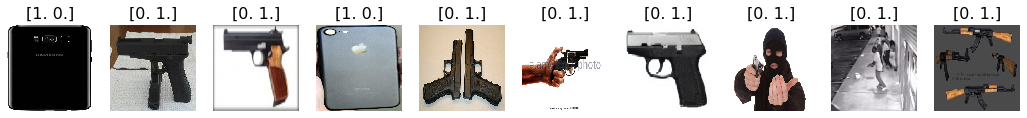

In [65]:
# peek at 10 images in the train set
plots(train_images[10:20], titles = train_labels[10:20])

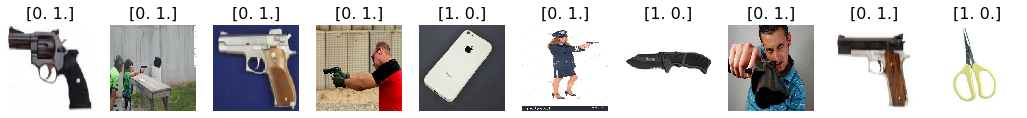

In [66]:
# peek at 10 images in the test set
plots(test_images[100:110], titles = test_labels[100:110])

In [67]:
# Explore dataset again
m_train = train_images.shape[0]  # number of images in train
num_px = train_images.shape[1]  # number of pixels
m_test = test_images.shape[0]  # number of images in test
m_val = val_images.shape[0]  # number of images in validation 

print ("Number of training samples: " + str(m_train))
print ("Number of testing samples: " + str(m_test))
print ("Number of validation samples: " + str(m_val))
print('-'*40)
print ("train_images shape: " + str(train_images.shape))
print ("train_labels shape: " + str(train_labels.shape))
print('-'*40)
print ("test_images shape: " + str(test_images.shape))
print ("test_labels shape: " + str(test_labels.shape))
print('-'*40)
print ("val_images shape: " + str(val_images.shape))
print ("val_labels shape: " + str(val_labels.shape))

Number of training samples: 3566
Number of testing samples: 1209
Number of validation samples: 1196
----------------------------------------
train_images shape: (3566, 256, 256, 3)
train_labels shape: (3566, 2)
----------------------------------------
test_images shape: (1209, 256, 256, 3)
test_labels shape: (1209, 2)
----------------------------------------
val_images shape: (1196, 256, 256, 3)
val_labels shape: (1196, 2)


In [68]:
train_images.shape

(3566, 256, 256, 3)

In [69]:
# reshapes the images to (num of images in set, num of pixels ie. 64 x 64 x 3 = 12288)
train_img = train_images.reshape(train_images.shape[0], -1) 
test_img = test_images.reshape(test_images.shape[0], -1)
val_img = val_images.reshape(val_images.shape[0], -1)

print(train_img.shape)
print(test_img.shape)
print(val_img.shape)

(3566, 196608)
(1209, 196608)
(1196, 196608)


In [88]:
train_images.shape

(3566, 256, 256, 3)

In [70]:
train_labels.shape

(3566, 2)

In [71]:
# reshape the target 
train_y = np.reshape(train_labels[:,0], (3566,1))
test_y = np.reshape(test_labels[:,0], (1209,1))
val_y = np.reshape(val_labels[:,0], (1196,1))

In [72]:
train_labels

array([[0., 1.],
       [1., 0.],
       [1., 0.],
       ...,
       [0., 1.],
       [1., 0.],
       [0., 1.]], dtype=float32)

In [73]:
print(train_y)
print(train_y.shape)

[[0.]
 [1.]
 [1.]
 ...
 [0.]
 [1.]
 [0.]]
(3566, 1)


## Build Baseline Dense Network

In [93]:
# Build a baseline fully connected model
np.random.seed(42)

baseline_model = models.Sequential()

baseline_model.add(layers.Dense(64, activation='relu', input_shape=(196608,))) 

# 2 hidden layers
baseline_model.add(layers.Dense(32, activation='relu'))
baseline_model.add(layers.Dense(16, activation='relu'))
baseline_model.add(layers.Dense(1, activation='sigmoid')) 

In [94]:
baseline_model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_12 (Dense)            (None, 64)                12582976  
                                                                 
 dense_13 (Dense)            (None, 32)                2080      
                                                                 
 dense_14 (Dense)            (None, 16)                528       
                                                                 
 dense_15 (Dense)            (None, 1)                 17        
                                                                 
Total params: 12,585,601
Trainable params: 12,585,601
Non-trainable params: 0
_________________________________________________________________


In [95]:
# terminate training if doesnt improve on specified min_delta for 5 epochs
trainCallback = EarlyStopping(monitor='loss', min_delta = 1e-4, patience = 5)

**⏰ Below code runs for about 12 min**

In [96]:
baseline_model.compile(optimizer='adam',
              loss='binary_crossentropy', # for binary classification (gun or not gun)
              metrics=['accuracy'])

baseline_model = baseline_model.fit(train_img,
                                    train_y,
                                    epochs=100,
                                    batch_size=64,
                                    validation_data=(val_img, val_y),
                                    callbacks=[trainCallback])

Epoch 1/100


2022-08-01 13:16:03.822228: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


56/56 [==============================] - ETA: 0s - loss: 9.1470 - accuracy: 0.5953

2022-08-01 13:16:10.520726: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


56/56 [==============================] - 8s 140ms/step - loss: 9.1470 - accuracy: 0.5953 - val_loss: 1.7930 - val_accuracy: 0.6856
Epoch 2/100
56/56 [==============================] - 6s 115ms/step - loss: 6.1200 - accuracy: 0.6214 - val_loss: 3.9859 - val_accuracy: 0.7023
Epoch 3/100
56/56 [==============================] - 7s 117ms/step - loss: 2.1379 - accuracy: 0.6983 - val_loss: 1.9515 - val_accuracy: 0.6054
Epoch 4/100
56/56 [==============================] - 7s 118ms/step - loss: 2.8079 - accuracy: 0.6660 - val_loss: 3.3950 - val_accuracy: 0.6998
Epoch 5/100
56/56 [==============================] - 7s 120ms/step - loss: 1.7559 - accuracy: 0.7162 - val_loss: 0.8639 - val_accuracy: 0.7684
Epoch 6/100
56/56 [==============================] - 7s 118ms/step - loss: 0.9432 - accuracy: 0.7459 - val_loss: 1.1946 - val_accuracy: 0.7274
Epoch 7/100
56/56 [==============================] - 7s 117ms/step - loss: 2.8841 - accuracy: 0.6795 - val_loss: 2.0980 - val_accuracy: 0.7132
Epoch 8/100

## Save the model as a .pkl file

In [97]:
# # use the built-in open() function to open a file
# output_file = open("baseline_model.pkl", "wb") # "wb" means "write as bytes"

# # dump the variable's contents into the file
# joblib.dump(baseline_model, output_file)

# # close the file, ensuring nothing stays in the buffer
# output_file.close()

INFO:tensorflow:Assets written to: ram://3e1266e4-17ff-4271-9429-81e6d772304f/assets


In [98]:
# use the built-in open() function again, this time to read
model_file = open("baseline_model.pkl", "rb") # "rb" means "read as bytes"
# load the variable's contents from the file into a variable
loaded_baseline_model = joblib.load(model_file)
# close the file
model_file.close()

In [99]:
# create a helper function that returns loss and accuracy results from model
# also plots the loss and accuracy 

def model_results(mod, train_img, train_y, test_img, test_y):
    """ Takes in the model, image set, and array y of targets for training and test sets
        and returns the model's loss and accuracy scores.
        Also returns a plot of the training and validation scores. 
    """
    # returns loss and accuracy scores for training and test sets
    results_train = mod.model.evaluate(train_img, train_y)
    results_test = mod.model.evaluate(test_img, test_y)
    
    # get the accuracy and loss for training and validation
    acc = mod.history['accuracy']
    val_acc = mod.history['val_accuracy']
    loss = mod.history['loss']
    val_loss = mod.history['val_loss']
    epochs = range(len(acc))
    
    # return train and test loss and accuracy
    print("Train Results Loss:", round(results_train[0],5))
    print("Train Results Accuracy:", round(results_train[1], 5))
    print("-"* 50)
    print("Test Results Loss:", round(results_test[0],5))
    print("Test Results Accuracy:", round(results_test[1], 5))
    
    # plot the Traininng and Validation Accuracy and Loss
    plt.plot(epochs, acc, label='Training acc')
    plt.plot(epochs, val_acc, label='Validation acc')
    plt.title('Training and Validation accuracy', fontweight = "bold")
    plt.legend()
    plt.figure()
    plt.plot(epochs, loss, label='Training loss')
    plt.plot(epochs, val_loss, label='Validation loss')
    plt.title('Training and Validation loss', fontweight = "bold")
    plt.legend()
    plt.show()

### Baseline Model Results

2022-08-01 13:19:54.967999: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


38/38 [==============================] - 2s 64ms/step - loss: 0.6204 - accuracy: 0.7527
Train Results Loss: 0.43416
Train Results Accuracy: 0.78688
--------------------------------------------------
Test Results Loss: 0.62039
Test Results Accuracy: 0.75269


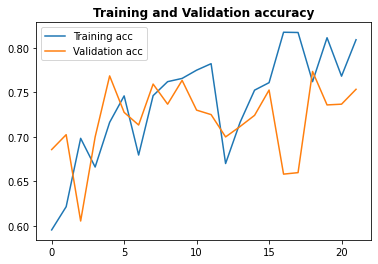

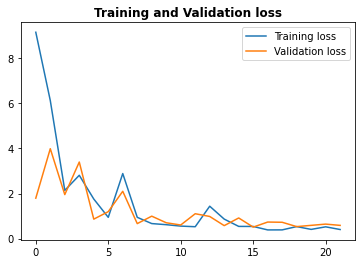

In [100]:
# get baseline model results
model_results(loaded_baseline_model, train_img, train_y, test_img, test_y)

In [167]:
# another way to check loss and accuracy score
baseline_model.model.evaluate(test_img, test_y)

38/38 [==============================] - 2s 63ms/step - loss: 0.6204 - accuracy: 0.7527


[0.6203905940055847, 0.7526881694793701]

In [168]:
# create helper function to plot test results as a confusion matrix
def get_test_results(mod, test_img, test_y):
    """
    Takes in the model, test image set, and test_y set
    and returns the model's accuracy and confusion matrix.
    """
    # return the loss and accuracy scores for the test set
    mod.model.evaluate(test_img, test_y)
    
    # get probabilites from the prediction on the test image set
    y_proba = mod.model.predict(test_img)
    
    # get assigned index values; ie. predicted labels
    predicted = y_proba.round()

    # plot confusion matrix on test set
    cm = confusion_matrix(test_y, predicted)

    disp = ConfusionMatrixDisplay(
        confusion_matrix=cm)

    disp.plot(cmap=plt.cm.Blues)
    plt.show()

38/38 [==============================] - 3s 79ms/step


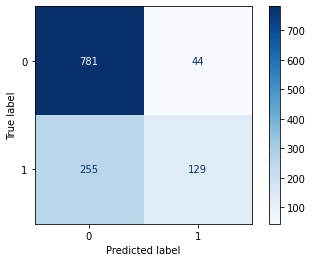

In [169]:
# get confusion matrix and test results for test image set
get_test_results(baseline_model, test_img, test_y)

## Building a CNN

In [118]:
train_images.shape

(3566, 256, 256, 3)

In [117]:
train_img.shape

(3566, 196608)

In [170]:
cnn_model = models.Sequential()
cnn_model.add(layers.Conv2D(32, (3, 3), activation='relu',
                        input_shape=(256, 256, 3)))
cnn_model.add(layers.MaxPooling2D((2, 2)))

cnn_model.add(layers.Conv2D(32, (4, 4), activation='relu'))
cnn_model.add(layers.MaxPooling2D((2, 2)))

cnn_model.add(layers.Conv2D(64, (3, 3), activation='relu'))
cnn_model.add(layers.MaxPooling2D((2, 2)))

cnn_model.add(layers.Flatten())
cnn_model.add(layers.Dense(64, activation='relu'))
cnn_model.add(layers.Dense(1, activation='sigmoid'))

cnn_model.compile(loss='binary_crossentropy',
              optimizer="sgd",
              metrics=['accuracy'])

In [171]:
cnn_model.summary()

Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_12 (Conv2D)          (None, 254, 254, 32)      896       
                                                                 
 max_pooling2d_11 (MaxPoolin  (None, 127, 127, 32)     0         
 g2D)                                                            
                                                                 
 conv2d_13 (Conv2D)          (None, 124, 124, 32)      16416     
                                                                 
 max_pooling2d_12 (MaxPoolin  (None, 62, 62, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_14 (Conv2D)          (None, 60, 60, 64)        18496     
                                                                 
 max_pooling2d_13 (MaxPoolin  (None, 30, 30, 64)     

In [172]:
# create a CNN model
cnn_model = cnn_model.fit(train_images,
                    train_y,
                    epochs=10,
                    batch_size=32,
                    validation_data=(val_images, val_y))

Epoch 1/10


2022-08-01 14:54:40.436096: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


112/112 [==============================] - ETA: 0s - loss: 0.6290 - accuracy: 0.6495

2022-08-01 14:55:07.694171: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


112/112 [==============================] - 31s 274ms/step - loss: 0.6290 - accuracy: 0.6495 - val_loss: 0.5852 - val_accuracy: 0.6681
Epoch 2/10
112/112 [==============================] - 28s 252ms/step - loss: 0.5816 - accuracy: 0.6691 - val_loss: 0.5516 - val_accuracy: 0.6831
Epoch 3/10
112/112 [==============================] - 28s 254ms/step - loss: 0.5360 - accuracy: 0.7193 - val_loss: 0.4840 - val_accuracy: 0.7575
Epoch 4/10
112/112 [==============================] - 28s 254ms/step - loss: 0.4776 - accuracy: 0.7588 - val_loss: 0.4373 - val_accuracy: 0.8094
Epoch 5/10
112/112 [==============================] - 28s 253ms/step - loss: 0.4401 - accuracy: 0.7818 - val_loss: 0.4292 - val_accuracy: 0.7977
Epoch 6/10
112/112 [==============================] - 28s 253ms/step - loss: 0.4053 - accuracy: 0.8146 - val_loss: 0.3747 - val_accuracy: 0.8328
Epoch 7/10
112/112 [==============================] - 28s 253ms/step - loss: 0.3799 - accuracy: 0.8306 - val_loss: 0.3778 - val_accuracy: 0.8

In [173]:
# # use the built-in open() function to open a file
# output_file = open("cnn_model.pkl", "wb") # "wb" means "write as bytes"

# # dump the variable's contents into the file
# joblib.dump(cnn_model, output_file)

# # close the file, ensuring nothing stays in the buffer
# output_file.close()

INFO:tensorflow:Assets written to: ram://f8cb36a0-d4b3-4f4c-9291-1d35bac311b9/assets


INFO:tensorflow:Assets written to: ram://f8cb36a0-d4b3-4f4c-9291-1d35bac311b9/assets


In [174]:
# use the built-in open() function again, this time to read
cnn_model_file = open("cnn_model.pkl", "rb") # "rb" means "read as bytes"
# load the variable's contents from the file into a variable
loaded_cnn_model = joblib.load(cnn_model_file)
# close the file
cnn_model_file.close()

2022-08-01 15:00:47.615509: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


38/38 [==============================] - 4s 95ms/step - loss: 0.3232 - accuracy: 0.8594
Train Results Loss: 0.27858
Train Results Accuracy: 0.87998
--------------------------------------------------
Test Results Loss: 0.32316
Test Results Accuracy: 0.85939


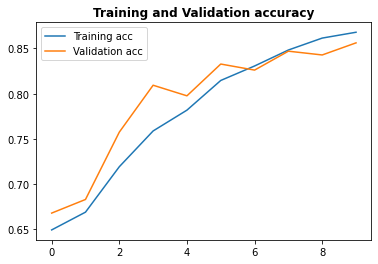

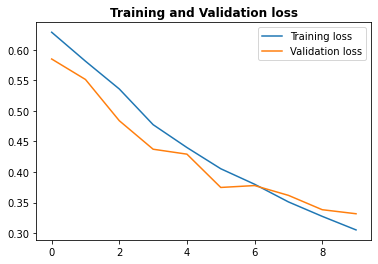

In [175]:
# get baseline model results
model_results(loaded_cnn_model, train_images, train_y, test_images, test_y)

 1/38 [..............................] - ETA: 8s

2022-08-01 15:02:49.147739: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


38/38 [==============================] - 4s 93ms/step


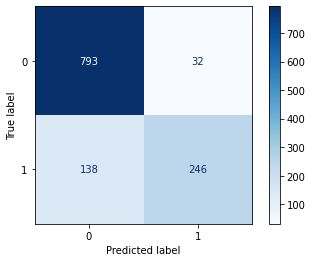

In [179]:
# get confusion matrix and test results for test image set
get_test_results(cnn_model, test_images, test_y)

In [176]:
# get probabilities from the predictions
y_proba = history.model.predict(test_images)
y_proba

38/38 [==============================] - 4s 99ms/step


array([[0.00130114],
       [0.00156   ],
       [0.07252626],
       ...,
       [0.04855711],
       [0.00012919],
       [0.00083312]], dtype=float32)

In [158]:
# get assigned index values; ie. predicted labels
predicted_cnn = y_proba.round()

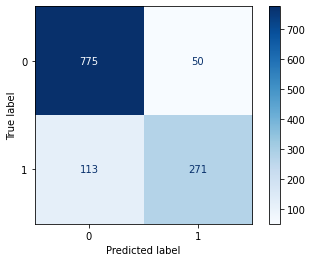

In [159]:
# plot confusion matrix on test set
cm = confusion_matrix(test_y, predicted_cnn)

disp = ConfusionMatrixDisplay(
    confusion_matrix=cm)

disp.plot(cmap=plt.cm.Blues)
plt.show()